Does the performance of the model depend on the initialization? 
- How robust are the probabilities?
- How robust is the optimal K ? 


In [1]:
import numpy as np 
import sys
import torch
import matplotlib.pyplot as plt
sys.path.append('../src/')
sys.path.append('../data/')

from generalist_class import Generalist
from tqdm import tqdm

### Choose some MSA (I will choose p53) and run two models, then plot the probabilities 

In [3]:
from data_process_fns import Convert_fastaToNp
FastaFilePath  = '../data/msa_p53_unimsa.fa' # file path of the fasta file 
data_one_hot = Convert_fastaToNp(filepath = FastaFilePath, binary = True, labels_inc =True)


### Training the model

In [13]:
## initialize generalist 
model0 = Generalist(data_one_hot, k = 32, param_init = 'rand')
model0.train()
model1 = Generalist(data_one_hot, k = 32, param_init = 'rand')
model1.train()

running on cpu
one hot encoded data of size torch.Size([21, 785, 341])
started inference...
takes 0.13371610641479492 seconds for the first step
inference is over
step on avg takes 0.09767691851741049 seconds 
inference done in 0.7195532997449239 minutes for k = 32, in 442 steps
running on cpu
one hot encoded data of size torch.Size([21, 785, 341])
started inference...
takes 0.10574793815612793 seconds for the first step
inference is over
step on avg takes 0.09795346842632034 seconds 
inference done in 0.7215905507405599 minutes for k = 32, in 442 steps


### print the Log likelihood array and  pi and flatten and plot 

In [14]:
larr0 = model0.Larr ; larr1 = model1.Larr
larr0 = larr0.numpy() ; larr1 = larr1.numpy()

Text(0, 0.5, 'log likelihood')

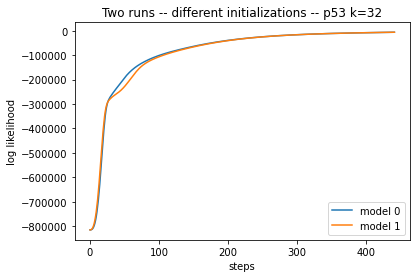

In [15]:
plt.plot(larr0,label =  'model 0')
plt.plot(larr1, label = 'model 1')
plt.legend()
plt.title('Two runs -- different initializations -- p53 k=32')
plt.xlabel('steps')
plt.ylabel('log likelihood')

In [21]:
print(larr0[-1])
print(larr1[-1])

-6406.2876
-6399.94


In [17]:
pi0 = model0.pi ; pi1 = model1.pi
pi0 = pi0.numpy() ; pi1 = pi1.numpy()

# pi0 = np.reshape(pi0 , (...,1))

In [18]:
pi1.shape

(21, 785, 341)

In [19]:
pi0 = pi0.flatten() ; pi1 = pi1.flatten()

Text(0.5, 1.0, 'Two runs -- different initializations -- p53, k = 32')

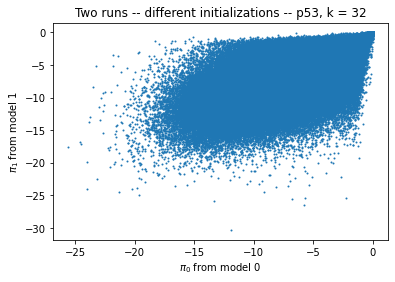

In [22]:
plt.scatter(np.log10(pi0), np.log10(pi1), s = 1)#, alpha = .05)
plt.xlabel(r'$\pi_0$ from model 0')
plt.ylabel(r'$\pi_1$ from model 1')
plt.title('Two runs -- different initializations -- p53, k = 32')
# plt.xlim([.2,.8])
# plt.ylim([.2,.8])

### Try initialization with random points from a Gaussian distribution

In [26]:
nA, N , L = data_one_hot.shape
k = 32
z_initial = np.random.randn(N,k)
theta_initial = np.random.randn(nA,k,L)

In [28]:
z_initial = torch.from_numpy(z_initial)

In [29]:
theta_initial = torch.from_numpy(theta_initial)

In [30]:
model_new = Generalist(one_hot_data = data_one_hot, k = k,  z_init =  z_initial, t_init = theta_initial)

In [31]:
model_new.train()

running on cpu
one hot encoded data of size torch.Size([21, 785, 341])
started inference...
takes 0.11075615882873535 seconds for the first step
inference is over
step on avg takes 0.10042970228076278 seconds 
inference done in 1.3424103538195291 minutes for k = 32, in 802 steps


In [32]:
larr_new = model_new.Larr
larr_new[-1]

tensor(-9658.3984)

### GENERATE SEQUENCES FROM BOTH 

In [31]:
ngen = 785 #same number of sequences in natural MSA 
gen0 = model0.generate(nGen = ngen) # output_binary = False
gen1 = model1.generate(nGen=ngen)

In [32]:
## Test the stats 
from performance_fns import Calc_nBody_Corr, calculate_r_metric


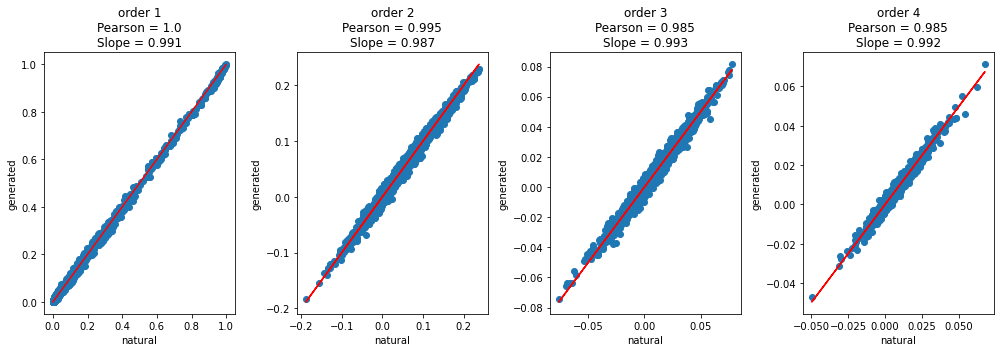

In [34]:
order_list = [1,2,3,4]
fig, ax = plt.subplots(ncols = len(order_list), figsize = (14,5))
i = 0
for order in order_list: 
    freq_og, freq_gen =  Calc_nBody_Corr(data_one_hot, gen1, n = order, mean_removed = True) #nTest = 7000 ,mean_removed = True
    r = np.corrcoef(freq_og, freq_gen)[0,1] #pearson corr coeff
    a, b = np.polyfit(freq_og, freq_gen, deg=1) #slope of linear fit line
    ax[i].scatter(freq_og, freq_gen)
    ax[i].plot(freq_og, freq_og, c = 'r')
    ax[i].set_title(f'order {order}\nPearson = {np.round(r,3)}\nSlope = {np.round(a,3)}')
    ax[i].set_xlabel(f'natural')
    ax[i].set_ylabel(f'generated')
    i+=1 
plt.tight_layout()

In [35]:
from performance_fns import calc_ham_arr , cal_ham_randompairs


In [38]:
generated_data = gen1
min_ham_tomsa = calc_ham_arr(data_one_hot, generated_data) #min hamming distance between generated sequence and MSA
min_ham_nat = calc_ham_arr(data_one_hot, data_one_hot , same_data = True) # minimum hamming distance between natural sequences and natural neighbors
min_ham_gen = calc_ham_arr(generated_data, generated_data , same_data = True)# minimum hamming distance between generated sequences and generated neighbors
rand_ham_gen = cal_ham_randompairs(generated_data, generated_data) # hamming distance between random pairs in generated sequences - default number of pairs = 1000
rand_ham_nat = cal_ham_randompairs(data_one_hot, data_one_hot) # hamming distance between random pairs in natural sequences - default number of pairs = 1000

two datasets are the same, removing the examined sequence from comparison
two datasets are the same, removing the examined sequence from comparison


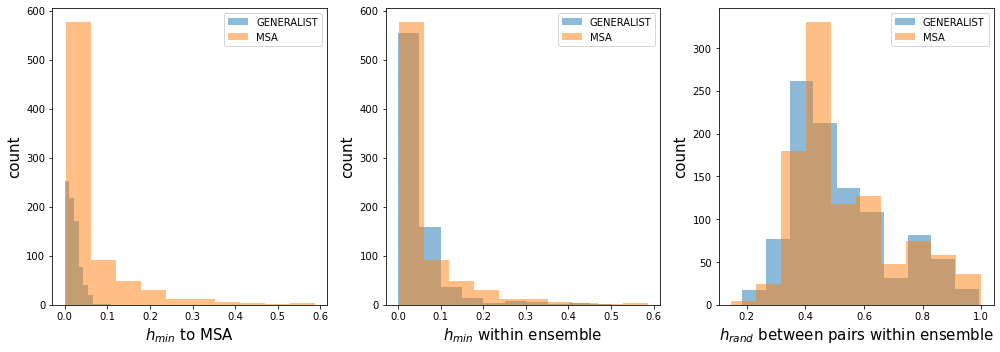

In [39]:
fig, ax = plt.subplots(ncols = 3, figsize = (14,5))
i = 0
ax[i].hist(min_ham_tomsa, label = 'GENERALIST', alpha = .5)
ax[i].hist(min_ham_nat, label = 'MSA', alpha = .5)
ax[i].set_xlabel(r'$h_{min}$ to MSA', fontsize = 15)
ax[i].set_ylabel('count', fontsize = 15)
ax[i].legend()
i+=1 
ax[i].hist(min_ham_gen, label = 'GENERALIST', alpha = .5)
ax[i].hist(min_ham_nat, label = 'MSA', alpha = .5)
ax[i].set_xlabel(r'$h_{min}$ within ensemble', fontsize = 15)
ax[i].set_ylabel('count', fontsize = 15)
ax[i].legend()

i+=1 
ax[i].hist(rand_ham_gen, label = 'GENERALIST', alpha = .5)
ax[i].hist(rand_ham_nat, label = 'MSA', alpha = .5)
ax[i].set_xlabel(r'$h_{rand}$ between pairs within ensemble', fontsize = 15)
ax[i].set_ylabel('count', fontsize = 15)
ax[i].legend()


plt.tight_layout()

### Comparing SVD initialization to random initialization 

In [33]:
nA, nS, nP = data_one_hot.shape
print(data_one_hot.shape)
data_resh = np.swapaxes(data_one_hot, 0,-1)
data_resh = np.swapaxes(data_resh, 0,1)
data_resh = np.reshape(data_resh, (nS, nP*nA))
u, s, vh = np.linalg.svd(data_resh, full_matrices=False)
# print(u.shape)
# print((torch.diag(s) @ vh).shape)
z = u[:,:k]
t = (np.diag(s)[:k,:k] @ vh[:k,:])
print(t.shape)
t = np.reshape(t , (nA,k,nP))

(21, 785, 341)
(32, 7161)


In [34]:
print((np.diag(s) @ vh).shape)

(785, 7161)


In [35]:
## random init 
k = 32
thresh = .1
model_rand = Generalist(one_hot_data=data_one_hot , k = k, param_init = 'rand')
model_svd = Generalist(one_hot_data=data_one_hot , k = k, param_init = 'svd')
model_rand.train(thresh = thresh )
model_svd.train(thresh = thresh )

running on cpu
one hot encoded data of size torch.Size([21, 785, 341])
started inference...
takes 0.1500248908996582 seconds for the first step
inference is over
step on avg takes 0.09784082246644515 seconds 
inference done in 1.8540835857391358 minutes for k = 32, in 1137 steps
running on cpu
one hot encoded data of size torch.Size([21, 785, 341])
started inference...
takes 0.1314558982849121 seconds for the first step
inference is over
step on avg takes 0.09763129354620946 seconds 
inference done in 1.7671264131863913 minutes for k = 32, in 1086 steps


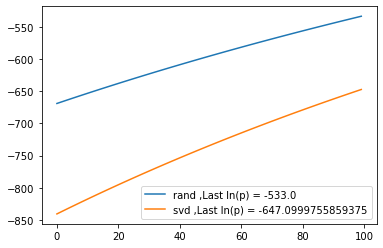

In [36]:
label = ['rand', 'svd']
models = [model_rand, model_svd]
for mi in range(len(models)):
    model = models[mi]
    lab = label[mi]
    Larr = model.Larr
    Larr = Larr.numpy()[-100:]
    
    plt.plot(Larr, label = lab + f' ,Last ln(p) = {np.round(Larr[-1],1)}')
plt.legend()

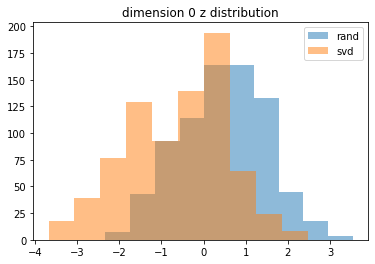

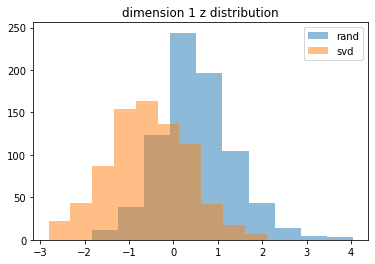

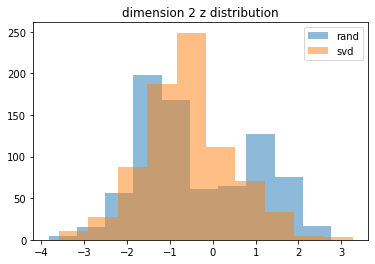

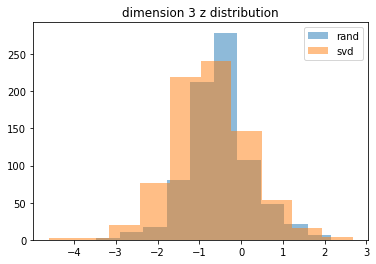

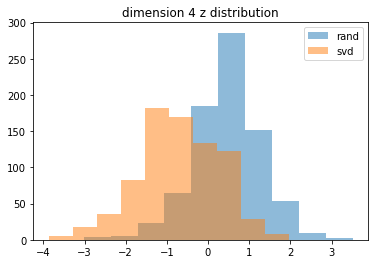

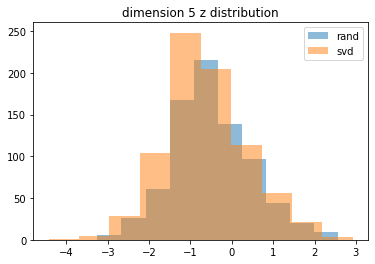

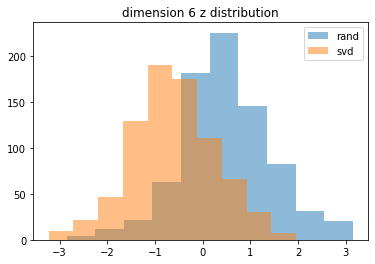

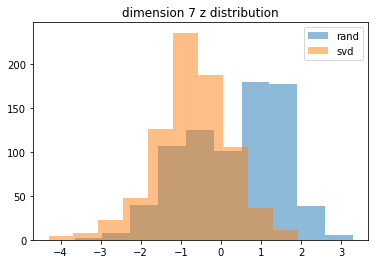

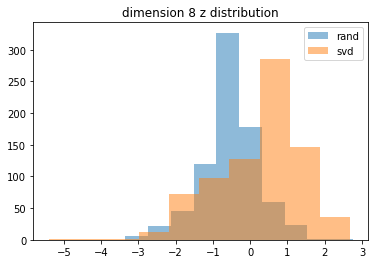

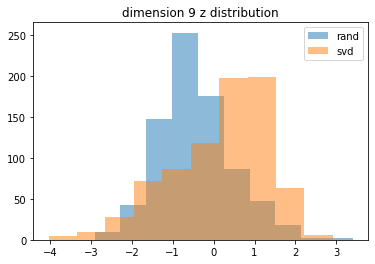

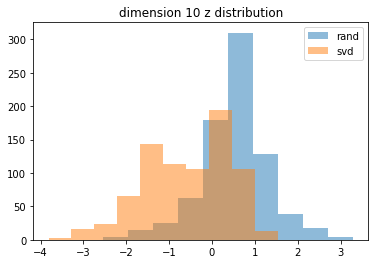

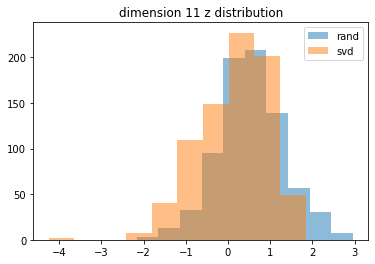

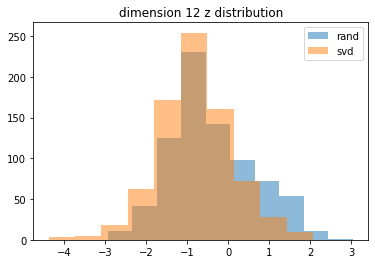

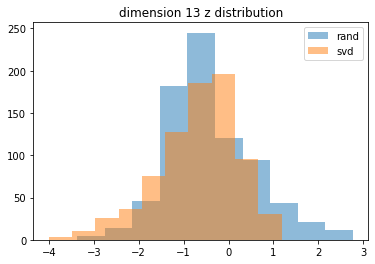

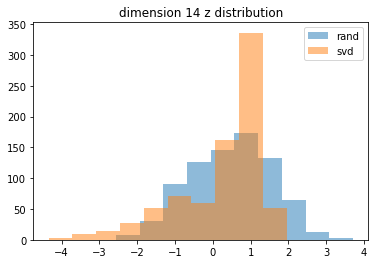

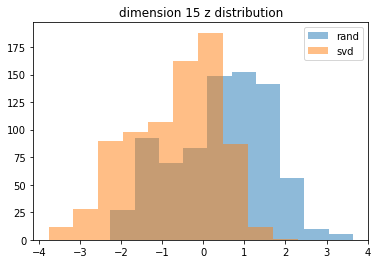

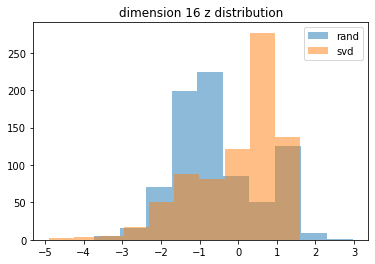

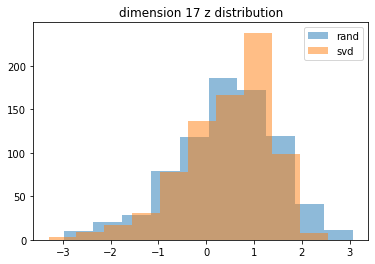

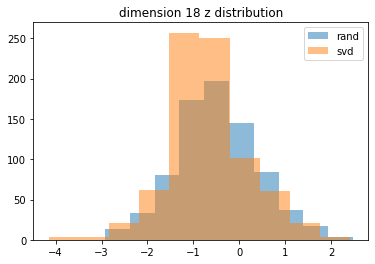

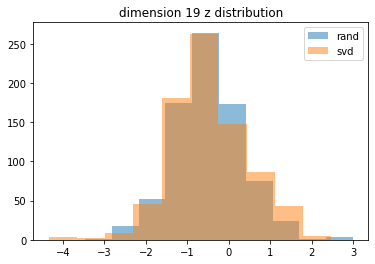

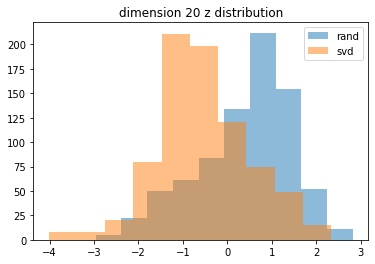

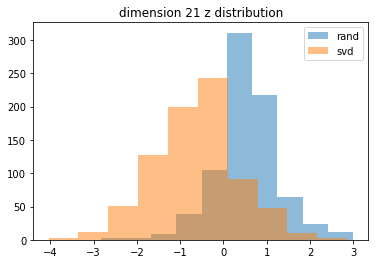

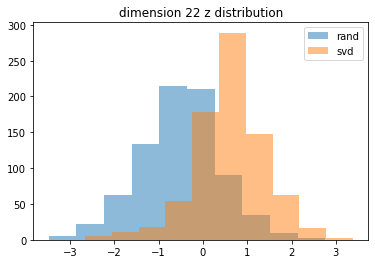

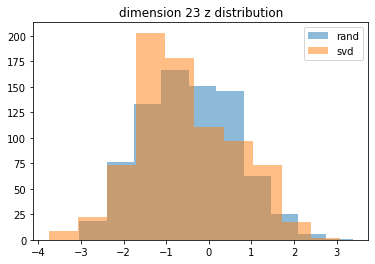

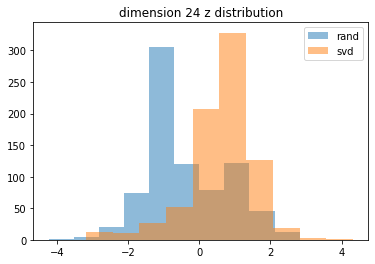

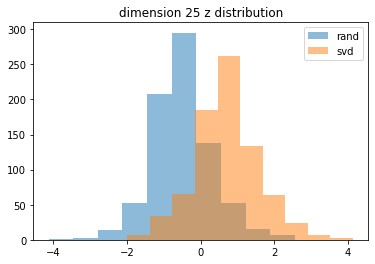

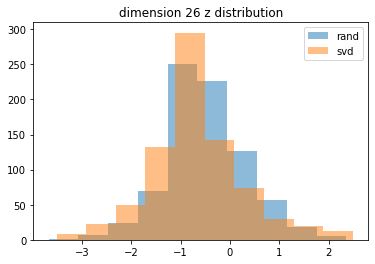

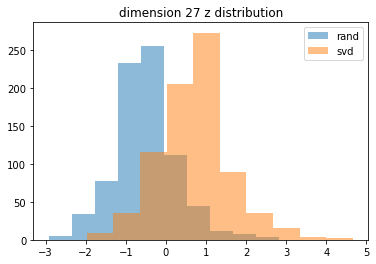

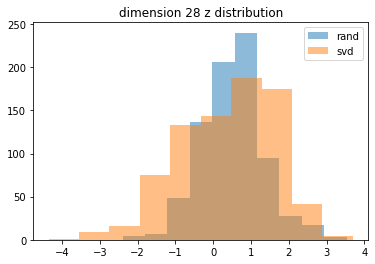

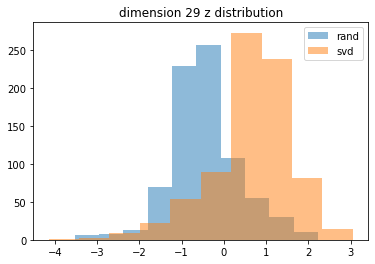

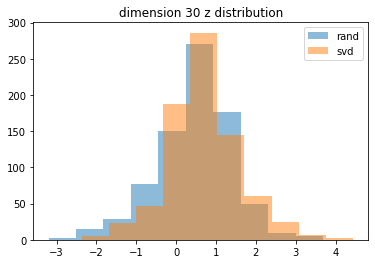

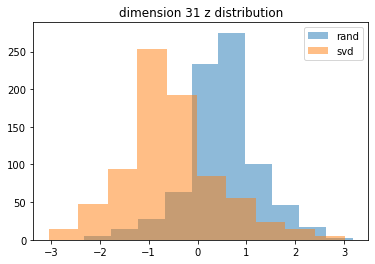

In [37]:
for dim in range(k):
    for mi in range(len(models)):
        model = models[mi]
        lab = label[mi]
        z = model.z
        z = z.numpy()
        plt.hist(z[:,dim], label = lab, alpha = .5)
    plt.title(f'dimension {dim} z distribution')
    plt.legend()
    plt.show()

In [39]:
## 
pi_ran= model_rand.pi
pi_ran = pi_ran.numpy()
pi_svd= model_svd.pi
pi_svd = pi_svd.numpy()

pi_ran = pi_ran.flatten()
pi_svd = pi_svd.flatten()

Text(0, 0.5, 'svd initialization pi')

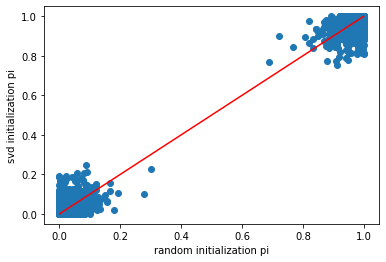

In [40]:
plt.scatter(pi_ran, pi_svd)
plt.plot(pi_ran, pi_ran, c = 'r')
plt.xlabel('random initialization pi')
plt.ylabel('svd initialization pi')
###